In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

# Chargement des données

> <span style="color:magenta">Base de données choisie : Pima Indians Diabetes Database</span>

> <span style="color:magenta">Objectif : diagnostiquer le diabète à partir d'un certain nombre n'observations</span>

In [2]:
tab = pd.read_csv("diabetes.csv")

In [3]:
tab

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
#Séparation de notre jeux de données en set d'entrainement et de validation
tabTrain, tabTest = train_test_split(tab, test_size=0.2, random_state=42)

In [5]:
tab['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

> <span style="color:magenta">Attention, nous sommes dans cas de classes déséquilibre. Il faudra doncveiller à choisir la métrique la plus appropriée </span>

# Selection de variable
## Approche classique

> <span style="color:magenta">On réalise des tests statisques classiques afin de determiner quelles sont les variables les plus discriminantes pour déceler le cepage d'origine.</span>

F-statistic = 39.670227393616074
p-value = 5.065127298052554e-10


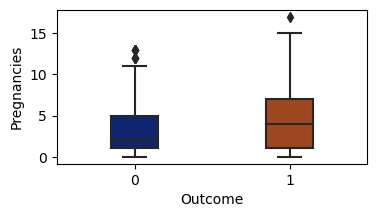

F-statistic = 213.1617521780386
p-value = 8.935431645287658e-43


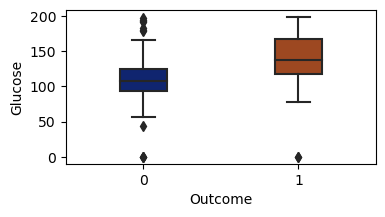

F-statistic = 3.2569503978889918
p-value = 0.07151390009774597


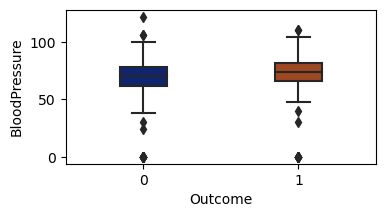

F-statistic = 4.304380905008434
p-value = 0.03834770482048333


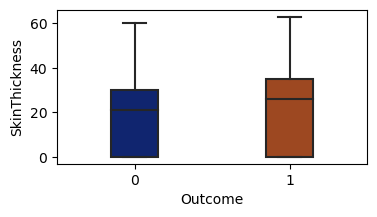

F-statistic = 13.281107531096266
p-value = 0.0002861864603602735


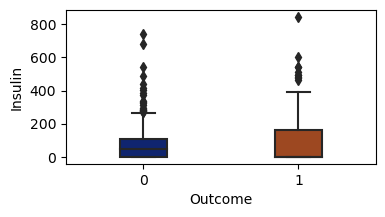

F-statistic = 71.77207210224542
p-value = 1.2298074873114397e-16


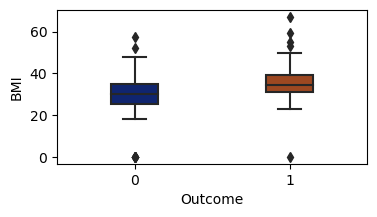

F-statistic = 23.871300204344447
p-value = 1.2546070101485626e-06


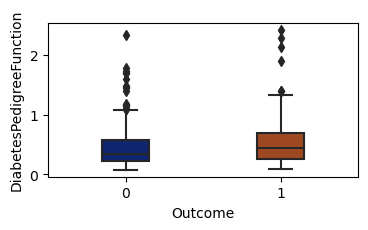

F-statistic = 46.14061123873557
p-value = 2.2099754606650332e-11


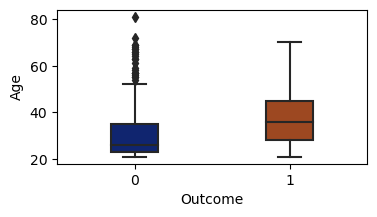

In [6]:
varList = tabTrain.columns[:8].tolist()
for var in varList :
    
    f_statistic, p_value = f_oneway(*[group[var] for name, group in tab.groupby("Outcome")])
    print('F-statistic =', f_statistic)
    print('p-value =', p_value)
    
    plt.figure(figsize = (4, 2))
    sns.boxplot(data = tabTrain, x = 'Outcome', y = var, orient='v', palette = 'dark', width=0.3)
    plt.show()

> <span style="color:magenta">Après avoir effectué un test d'ANOVA on peut enlever l variable "BloodPressure" , puisque ce dernier n'est en aucun cas discrinant. La variable "SkinThickness" est la imite, nous décidons donc de l'enlever.</span>

In [7]:
varToRemove = ["BloodPressure", "SkinThickness" ]
tabTrainClassic = tabTrain.drop(varToRemove, axis=1)
tabTestClassic = tabTest.drop(varToRemove, axis=1)

In [8]:
tabTestClassic

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,190,34.0,0.430,43,0
324,2,112,0,35.7,0.148,21,0
624,2,108,0,30.8,0.158,21,0
690,8,107,0,24.6,0.856,34,0
473,7,136,0,29.9,0.210,50,0
...,...,...,...,...,...,...,...
355,9,165,0,30.4,0.302,49,1
534,1,77,56,33.3,1.251,24,0
344,8,95,0,36.8,0.485,57,0
296,2,146,360,28.0,0.337,29,1


<AxesSubplot:>

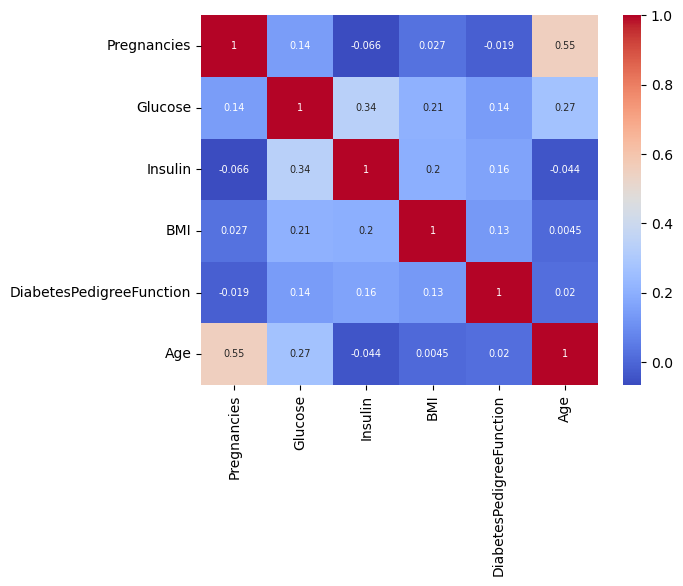

In [9]:
corrTab = tabTrainClassic.iloc[:, :6].corr()
sns.heatmap(corrTab, annot=True, cmap='coolwarm',annot_kws={'fontsize': 7})

> <span style="color:magenta">Aucune variabe n'est à enlever en étudiant la corrélation</span>

## Méthode wrapper
### Avec un RFC

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

In [11]:
x = tabTrain.drop("Outcome", axis=1)
y = tabTrain["Outcome"]

In [12]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,2,84,0,0,0,0.0,0.304,21
618,9,112,82,24,0,28.2,1.282,50
346,1,139,46,19,83,28.7,0.654,22
294,0,161,50,0,0,21.9,0.254,65
231,6,134,80,37,370,46.2,0.238,46
...,...,...,...,...,...,...,...,...
71,5,139,64,35,140,28.6,0.411,26
106,1,96,122,0,0,22.4,0.207,27
270,10,101,86,37,0,45.6,1.136,38
435,0,141,0,0,0,42.4,0.205,29


In [13]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]}

rfc = RandomForestClassifier()
gridSearchRFC = GridSearchCV(rfc, param_grid, cv = 10, scoring = make_scorer(balanced_accuracy_score))
gridSearchRFC.fit(x, y)

rfc = RandomForestClassifier(**gridSearchRFC.best_params_)
scorer = make_scorer(balanced_accuracy_score)
selector = RFECV(estimator = rfc, step=1, cv=10, scoring = scorer)
selector.fit(x, y)
print(selector.support_)

[False  True  True False  True  True  True  True]


In [14]:
#supression des colonnes non retenus
xTrainFildredRFC = x.iloc[:, selector.support_]
tab = tabTest.drop("Outcome", axis=1)
xTestFildredRFC = tab.iloc[:, selector.support_]

In [15]:
xTrainFildredRFC

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
60,84,0,0,0.0,0.304,21
618,112,82,0,28.2,1.282,50
346,139,46,83,28.7,0.654,22
294,161,50,0,21.9,0.254,65
231,134,80,370,46.2,0.238,46
...,...,...,...,...,...,...
71,139,64,140,28.6,0.411,26
106,96,122,0,22.4,0.207,27
270,101,86,0,45.6,1.136,38
435,141,0,0,42.4,0.205,29


### Avec un SVM

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, balanced_accuracy_score

In [17]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'sigmoid']}

svc = SVC()
gridSearchSVM = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 10, scoring = scorer)
gridSearchSVM.fit(x, y)
print(gridSearchSVM.best_params_)

svc = SVC(**gridSearchSVM.best_params_)
selector = RFECV(estimator = svc, step=1, cv=10, scoring = scorer)
x = tabTrain.drop("Outcome", axis=1)
selector.fit(x, y)

print("Nombre de variables sélectionnées: %d" % selector.n_features_)
print("Variables sélectionnées: %s" % x.columns[selector.support_])

xTrainFiltredSVM = x[x.columns[selector.support_]]
xTestFiltredSVM = tabTest[tab.columns[selector.support_]]

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Nombre de variables sélectionnées: 8
Variables sélectionnées: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [18]:
tab = tabTrain.drop("Outcome", axis=1)
xTrainFiltredSVM = x.iloc[:, selector.support_]

# Entrainement et évaluation des performances

## RFC sans sélection de variable

In [19]:
results = pd.DataFrame()
yTrain = tabTrain["Outcome"]
yTest = tabTest["Outcome"]

#entrainement sans variable séléctionné sur le RFC
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]}

rfcNorm = RandomForestClassifier()
gridSearchRFCNorm = GridSearchCV(rfcNorm, param_grid, cv = 10, scoring = make_scorer(balanced_accuracy_score))
gridSearchRFCNorm.fit(x, y)

rfcNorm = RandomForestClassifier(**gridSearchRFCNorm.best_params_)
rfcNorm.fit(x, y)

yHatTrain = rfcNorm.predict(x)
ballancedAccTrain = balanced_accuracy_score(y, yHatTrain)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["aucun"],
                      "Balanced accuracy": [ballancedAccTrain], "Data" : ["Cross-val"]})
results = pd.concat([results, newRow])

xTest = tabTest.drop("Outcome", axis=1)
yTest = tabTest["Outcome"] 
yHatTest = rfcNorm.predict(xTest)
ballancedAccTest = balanced_accuracy_score(yTest, yHatTest)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["aucun"],
                      "Balanced accuracy": [ballancedAccTest], "Data" : ["Test"]})
results = pd.concat([results, newRow])

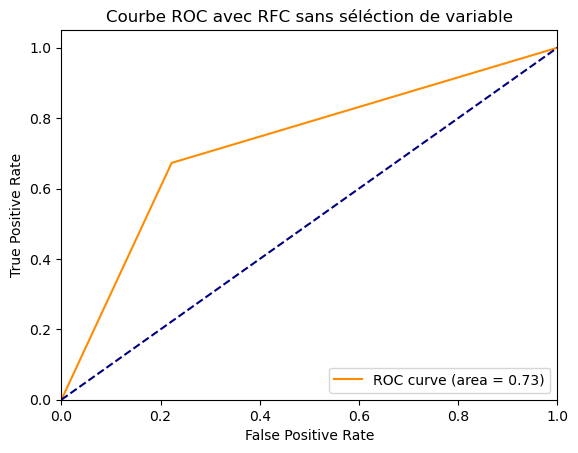

In [20]:
#Courbe roc
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(yTest, yHatTest)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC avec RFC sans séléction de variable')
plt.legend(loc="lower right")
plt.show()

## RFC avec selection de variable classique

In [21]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]}

rfcClass = RandomForestClassifier()
gridSearchRFCClass = GridSearchCV(rfcClass, param_grid, cv = 10, scoring = make_scorer(balanced_accuracy_score))

x = tabTrainClassic.drop("Outcome", axis=1)
gridSearchRFCClass.fit(x, y)

rfcClass = RandomForestClassifier(**gridSearchRFCClass.best_params_)
rfcClass.fit(x, y)

yHatTrain = rfcClass.predict(x)
ballancedAccTrain = balanced_accuracy_score(y, yHatTrain)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["classique"],
                      "Balanced accuracy": [ballancedAccTrain], "Data" : ["Cross-val"]})
results = pd.concat([results, newRow])

xTest = tabTestClassic.drop("Outcome", axis=1)
yHatTest = rfcClass.predict(xTest)
ballancedAccTest = balanced_accuracy_score(yTest, yHatTest)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["classique"],
                      "Balanced accuracy": [ballancedAccTest], "Data" : ["Test"]})
results = pd.concat([results, newRow])

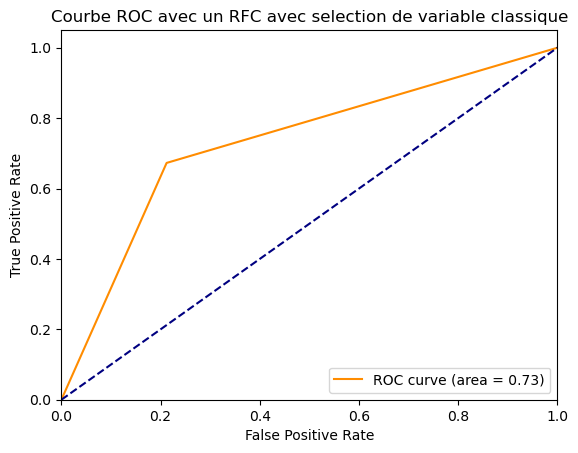

In [22]:
#Courbe roc
fpr, tpr, _ = roc_curve(yTest, yHatTest)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC avec un RFC avec selection de variable classique')
plt.legend(loc="lower right")
plt.show()

## RFC avec selection de variable avec la méthode wrapper

In [23]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]}

rfcWrap = RandomForestClassifier()
gridSearchRFCWrap = GridSearchCV(rfcWrap, param_grid, cv = 10, scoring = make_scorer(balanced_accuracy_score))

gridSearchRFCWrap.fit(xTrainFildredRFC, y)

rfcWrap = RandomForestClassifier(**gridSearchRFCWrap.best_params_)
rfcWrap.fit(xTrainFildredRFC, y)

yHatTrain = rfcWrap.predict(xTrainFildredRFC)
ballancedAccTrain = balanced_accuracy_score(y, yHatTrain)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["wrapper"],
                      "Balanced accuracy": [ballancedAccTrain], "Data" : ["Cross-val"]})
results = pd.concat([results, newRow])

yHatTest = rfcWrap.predict(xTestFildredRFC)
ballancedAccTest = balanced_accuracy_score(yTest, yHatTest)

newRow = pd.DataFrame({"Methode": ["RFC"], "Selection de variable" : ["wrapper"],
                      "Balanced accuracy": [ballancedAccTest], "Data" : ["Test"]})
results = pd.concat([results, newRow])

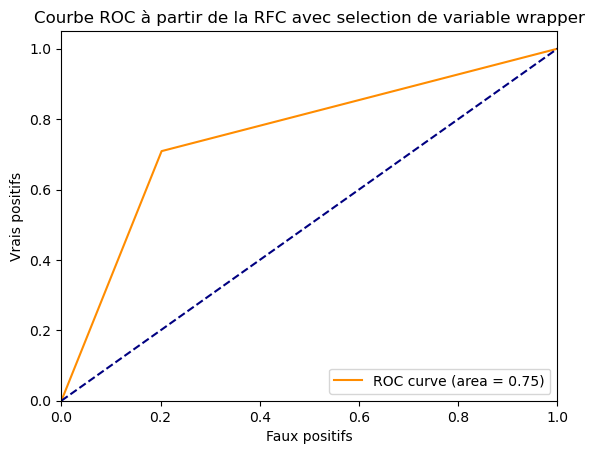

In [24]:
#Courbe roc
fpr, tpr, _ = roc_curve(yTest, yHatTest)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Faux positifs')
plt.ylabel('Vrais positifs')
plt.title('Courbe ROC à partir de la RFC avec selection de variable wrapper')
plt.legend(loc="lower right")
plt.show()

## SVM sans sélection de variable

In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10]}

svcNorm = SVC(kernel = "linear")
gridSearchSVMNorm = GridSearchCV(estimator = svcNorm, param_grid = param_grid, cv = 10, scoring = scorer)
gridSearchSVMNorm.fit(x, y)

svcNorm = SVC(**gridSearchSVMNorm.best_params_)
svcNorm.fit(x, y)

yHatTrain = svcNorm.predict(x)
ballancedAccTrain = balanced_accuracy_score(y, yHatTrain)

newRow = pd.DataFrame({"Methode": ["SVM"], "Selection de variable" : ["aucun"],
                      "Balanced accuracy": [ballancedAccTrain], "Data" : ["Cross-val"]})
results = pd.concat([results, newRow])

yHatTest = svcNorm.predict(xTest)
ballancedAccTest = balanced_accuracy_score(yTest, yHatTest)

newRow = pd.DataFrame({"Methode": ["SVM"], "Selection de variable" : ["aucun"],
                      "Balanced accuracy": [ballancedAccTest], "Data" : ["Test"]})
results = pd.concat([results, newRow])

In [ ]:
#Courbe roc
fpr, tpr, _ = roc_curve(yTest, yHatTest)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Faux positifs')
plt.ylabel('Vrais positifs')
plt.title('Courbe ROC avec le SVM sans selection de variable')
plt.legend(loc="lower right")
plt.show()

## SVM avec selection de variable classique

In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10]}

svcClass = SVC(kernel = "linear")
gridSearchSVMClass = GridSearchCV(estimator = svcClass, param_grid = param_grid, cv = 10, scoring = scorer)
gridSearchSVMClass.fit(x, y)

svcClass = SVC(**gridSearchSVMClass.best_params_)
svcClass.fit(x, y)

x = tabTrainClassic.drop("Outcome", axis=1)
yHatTrain = svcClass.predict(x)
ballancedAccTrain = balanced_accuracy_score(y, yHatTrain)

newRow = pd.DataFrame({"Methode": ["SVM"], "Selection de variable" : ["classique"],
                      "Balanced accuracy": [ballancedAccTrain], "Data" : ["Cross-val"]})
results = pd.concat([results, newRow])

yHatTest = svcClass.predict(xTest)
ballancedAccTest = balanced_accuracy_score(yTest, yHatTest)

newRow = pd.DataFrame({"Methode": ["SVM"], "Selection de variable" : ["classique"],
                      "Balanced accuracy": [ballancedAccTest], "Data" : ["Test"]})
results = pd.concat([results, newRow])

In [ ]:
#Courbe roc
fpr, tpr, _ = roc_curve(yTest, yHatTest)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Faux positifs')
plt.ylabel('Vrais positifs')
plt.title('Courbe ROC avec un SVM et selection de variable classique')
plt.legend(loc="lower right")
plt.show()

## SVM avec selection de variable avec la méthode wrapper

> <span style="color:magenta">Aucune variabe n'a été enlevée avec la méthode wrapper</span>

# Modèle à retenir

In [ ]:
results = results.drop(results[results["Data"] == "test"].index)

In [2]:
results

NameError: name 'results' is not defined

In [ ]:
import seaborn as sns
g = sns.FacetGrid(results, col = "Methode")
g.map_dataframe(sns.barplot, x = "Selection de variable", y = "Balanced accuracy",
                            palette = "dark", hue = "Data", errorbar = None,width = 0.5)
g.tick_params(axis = "x", rotation = 60)
plt.ylim(0, 1)
plt.yticks([0.1*i for i in range(11)])
plt.legend(loc = 'upper right')
plt.show